In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [32]:
train = pd.read_csv('Datasets/aps_failure_training_set.csv')
test = pd.read_csv('Datasets/aps_failure_test_set.csv')

In [33]:
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [34]:
train.isnull().sum()

class     0
aa_000    0
ab_000    0
ac_000    0
ad_000    0
         ..
ee_007    0
ee_008    0
ee_009    0
ef_000    0
eg_000    0
Length: 171, dtype: int64

In [35]:
import numpy as np
import pandas as pd

def clean_numeric_data(df, target_col='class', train_ref=None):
    """
    Cleans the Scania APS dataset by:
      - Replacing 'na' with NaN
      - Converting columns to numeric
      - Filling NaN values with median
    If train_ref is provided (for test set), uses medians from train_ref.
    """
    df = df.copy()
    df.replace("na", np.nan, inplace=True)

    # Convert all columns (except target) to numeric
    for col in df.columns:
        if col != target_col:
            df[col] = pd.to_numeric(df[col], errors='coerce')

            # Fill NaN values with median (from train_ref if available)
            if train_ref is not None:
                median_val = train_ref[col].median()
            else:
                median_val = df[col].median()

            df[col].fillna(median_val, inplace=True)

    return df


In [36]:
train = clean_numeric_data(train)
test = clean_numeric_data(test, train_ref=train)


/var/folders/h7/79wxf9hd7tv178w9xqkzs0mm0000gn/T/ipykernel_23406/313711155.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/var/folders/h7/79wxf9hd7tv178w9xqkzs0mm0000gn/T/ipykernel_23406/313711155.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [37]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 78.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 20.9+ MB


In [38]:
print("Missing values in train:", train.isna().sum().sum())
print("Missing values in test:", test.isna().sum().sum())

Missing values in train: 0
Missing values in test: 0


In [39]:
train['class'] = train['class'].map({'pos': 1, 'neg': 0})


In [40]:
test['class'] = test['class'].map({'neg': 0, 'pos': 1})


In [41]:
from sklearn.preprocessing import StandardScaler

X = train.drop('class', axis=1)
y = train['class']

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X)

In [42]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_train, y, test_size=0.7, stratify=y, random_state=42)


In [44]:
len(X_train)

18000

In [45]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)
log_reg_y_pred = log_reg.predict(X_test)
log_reg.score(X_test, y_test)


0.974452380952381

In [54]:
gb = GradientBoostingClassifier(
    n_estimators=200,     
    learning_rate=0.01,     
    max_depth=3,           
    random_state=42
)

gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [47]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, oob_score=True,          # ✅ must be enabled before training
    bootstrap=True)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
oob = rf.oob_score_
print(oob)

0.9888888888888889


In [52]:
models = {
    'Logistic Regression': (log_reg_y_pred, log_reg),
    'Random Forest': (y_pred_rf, rf),
    'GradientBoostingClassifier': (y_pred_gb, gb)
}

for name, (y_pred, model) in models.items():
    print(f"\n {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


 Logistic Regression
Accuracy: 0.974452380952381
Confusion Matrix:
 [[40362   938]
 [  135   565]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     41300
           1       0.38      0.81      0.51       700

    accuracy                           0.97     42000
   macro avg       0.69      0.89      0.75     42000
weighted avg       0.99      0.97      0.98     42000


 Random Forest
Accuracy: 0.9892619047619048
Confusion Matrix:
 [[41226    74]
 [  377   323]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     41300
           1       0.81      0.46      0.59       700

    accuracy                           0.99     42000
   macro avg       0.90      0.73      0.79     42000
weighted avg       0.99      0.99      0.99     42000


 GradientBoostingClassifier
Accuracy: 0.9910714285714286
Confusion Matrix:
 [[41253    47]
 [  328   3

Text(58.222222222222214, 0.5, 'Truth')

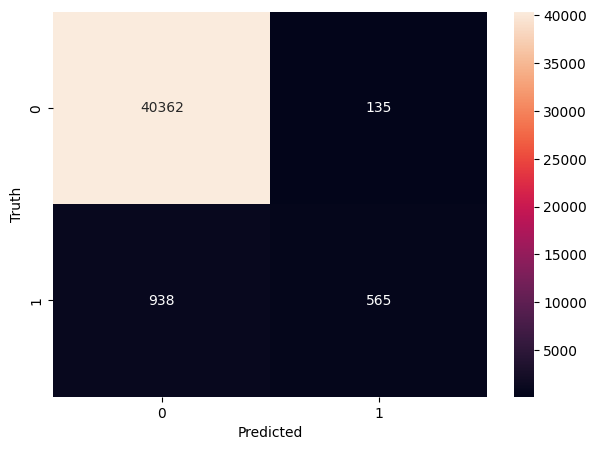

In [49]:
import seaborn as sn

cm = confusion_matrix(log_reg_y_pred, y_test)
plt.figure(figsize = (7,5))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(58.222222222222214, 0.5, 'Truth')

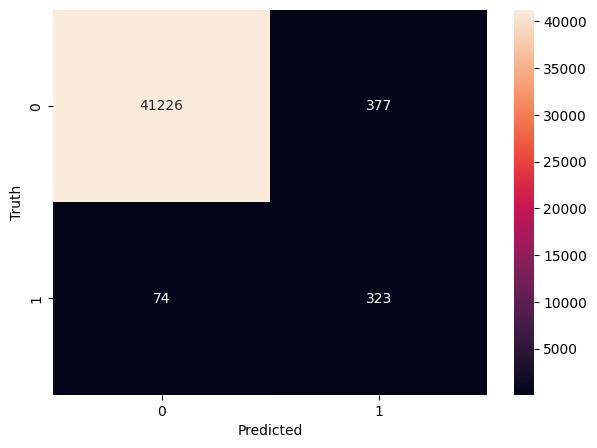

In [50]:
cm = confusion_matrix(y_pred_rf, y_test)
plt.figure(figsize = (7,5))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(58.222222222222214, 0.5, 'Truth')

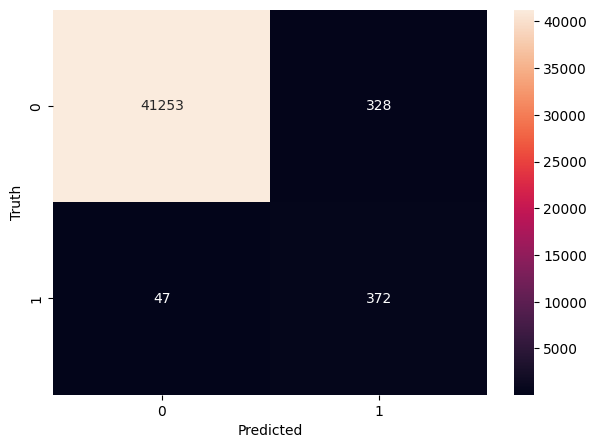

In [53]:
cm = confusion_matrix(y_pred_gb, y_test)
plt.figure(figsize = (7,5))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')